In [1]:
%load_ext autoreload
%aimport data_creater
%autoreload 1

from data_creater import *

In [2]:
stocks = companies()
tickers = stocks.values.tolist()

#Select stock to perform tests
ticker = tickers[2][1]

print("Stock ticker selected for testing: {}".format(ticker))

Stock ticker selected for testing: AAPL


In [3]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import RMSprop

def fixed_model(X,y, learn_rate):
    model = Sequential()
    model.add(LSTM(5,input_shape=(X.shape[1:])))
    model.add(Dense(y.shape[1], activation='tanh'))
      
    # compile the model
    optimizer = RMSprop(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def dynamic_model(X,y, learn_rate):
    model = Sequential()
    model.add(LSTM(X.shape[1],input_shape=(X.shape[1:])))
    model.add(Dense(y.shape[1], activation='tanh'))
      
    # compile the model
    optimizer = RMSprop(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def bidirectional_model(X,y, learn_rate):
    model = Sequential()
    model.add(Bidirectional(LSTM(X.shape[1],return_sequences=False), input_shape=(X.shape[1:])))
    model.add(Dense(X.shape[1]))
    model.add(Dense(y.shape[1], activation='tanh'))
      
    # compile the model
    optimizer = RMSprop(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def stacked_model(X,y, learn_rate):
    model = Sequential()
    model.add(LSTM(10,return_sequences=True, input_shape=(X.shape[1:])))
    model.add(LSTM(5))
    model.add(Dense(y.shape[1], activation='tanh'))
      
    # compile the model
    optimizer = RMSprop(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

#Create list of our models for use by the testing function.
models =[]
models.append(("Fixed",fixed_model))
models.append(("Dynamic",dynamic_model))
models.append(("Bidirectional",bidirectional_model))
models.append(("Stacked",stacked_model))

Using TensorFlow backend.


In [4]:
from collections import OrderedDict

def test_model(ticker,epochs,models,seq,window_sizes):
    #test result data
    sizes = []
    #seq_name = []
    model_name = []
    train_errors = []
    test_errors = []
    param_count = []
    
    for window_size in window_sizes:
        print("\nWindow size: {}".format(window_size))
        print('----------------')
        for model_item in models:
            seq_obj = seq[1](ticker,window_size,1)
            X_train,y_train,X_test,y_test = split_data(seq_obj)
            model = model_item[1](X_train,y_train,0.001)
            
            # fit model!
            model.fit(X_train, y_train, epochs=epochs, batch_size=50, verbose=0)

            # print out training and testing errors
            training_error = model.evaluate(X_train, y_train, verbose=0)
            testing_error = model.evaluate(X_test, y_test, verbose=0)
            msg = " > Model: {0:<15} Param count: {1:} \tTraining error: {2:.4f}\tTesting error: {3:.4f}"
            print(msg.format(model_item[0],model.count_params(),training_error,testing_error))

            #update result variables
            param_count.append(model.count_params())
            sizes.append(window_size)
            #seq_name.append(seq[0])
            model_name.append(model_item[0])
            train_errors.append(float("{0:.4f}".format(training_error)))
            test_errors.append(float("{0:.4f}".format( testing_error)))

    table= OrderedDict()
    table['Window Size'] = sizes
    table['Sequence Name'] =  [seq[0] for _ in range(len(sizes))]
    table['Model Name'] = model_name
    table['Ticker'] = [ticker for _ in range(len(sizes))]
    table['Training Error'] = train_errors
    table['Testing Error'] = test_errors
    table['Param Count'] = param_count
        
    return table


def update_test_table(*argv):
    file_path = "./data/model_test.csv"
    
    table = pd.read_csv(file_path)
    tickers = set( table['Ticker'].values.tolist())
    
    for item in argv:

        #first check if already exist 
        check = item['Ticker'][0]
        if check in tickers:
            #drop items
            idx = table[(table['Ticker']== check)  &  (table['Sequence Name']== item['Sequence Name'][0])].index
            table =  table.drop(idx)

        #append current test
        table = table.append(pd.DataFrame(item))

    table = table.reset_index(drop=True)
    table.to_csv(file_path, index = False)

def get_test_table():
    file_path = "./data/model_test.csv"
    return pd.read_csv(file_path)

In [5]:
seed = 7
np.random.seed(seed)

#Model testing variables
epochs =100
window_sizes =[5,7,10,20]

In [6]:
print("*** Simple Sequence Model Test for {} ***".format(ticker))
print("=" * 45)

seq_name = ('Simple',SimpleSequence)

test_1  = test_model(ticker,epochs,models,seq_name,window_sizes)
update_test_table(test_1)

*** Simple Sequence Model Test for AAPL ***

Window size: 5
----------------
 > Model: Fixed           Param count: 146 	Training error: 0.0025	Testing error: 0.0773
 > Model: Dynamic         Param count: 146 	Training error: 0.0025	Testing error: 0.0682
 > Model: Bidirectional   Param count: 341 	Training error: 0.0014	Testing error: 0.0202
 > Model: Stacked         Param count: 806 	Training error: 0.0020	Testing error: 0.0230

Window size: 7
----------------
 > Model: Fixed           Param count: 146 	Training error: 0.0019	Testing error: 0.0549
 > Model: Dynamic         Param count: 260 	Training error: 0.0016	Testing error: 0.0214
 > Model: Bidirectional   Param count: 617 	Training error: 0.0021	Testing error: 0.0237
 > Model: Stacked         Param count: 806 	Training error: 0.0023	Testing error: 0.0120

Window size: 10
----------------
 > Model: Fixed           Param count: 146 	Training error: 0.0016	Testing error: 0.0320
 > Model: Dynamic         Param count: 491 	Training er

In [7]:
print("*** Multi Sequence Model Test for {} ***".format(ticker))
print("=" * 45)

seq_name = ('Multi',MultiSequence)

test_2  = test_model(ticker,epochs,models,seq_name,window_sizes)
update_test_table(test_2)

*** Multi Sequence Model Test for AAPL ***

Window size: 5
----------------
 > Model: Fixed           Param count: 186 	Training error: 0.0015	Testing error: 0.0716
 > Model: Dynamic         Param count: 186 	Training error: 0.0017	Testing error: 0.0733
 > Model: Bidirectional   Param count: 421 	Training error: 0.0014	Testing error: 0.0616
 > Model: Stacked         Param count: 886 	Training error: 0.0014	Testing error: 0.0366

Window size: 7
----------------
 > Model: Fixed           Param count: 186 	Training error: 0.0013	Testing error: 0.0447
 > Model: Dynamic         Param count: 316 	Training error: 0.0016	Testing error: 0.0645
 > Model: Bidirectional   Param count: 729 	Training error: 0.0011	Testing error: 0.0466
 > Model: Stacked         Param count: 886 	Training error: 0.0013	Testing error: 0.0212

Window size: 10
----------------
 > Model: Fixed           Param count: 186 	Training error: 0.0013	Testing error: 0.0736
 > Model: Dynamic         Param count: 571 	Training err

In [7]:
table = get_test_table()

In [8]:
pd.pivot_table(table, values=['Training Error','Testing Error'], index=['Sequence Name']
               ,aggfunc={'Training Error':np.mean, 'Testing Error':np.mean} )

,Testing Error,Training Error
Sequence Name,,
Multi,0.032710,0.007954
Simple,0.032117,0.011487


In [9]:
pd.pivot_table(table, values=['Training Error','Testing Error'], index=['Ticker','Window Size']
               ,aggfunc={'Training Error':np.mean, 'Testing Error':np.mean} )

Testing Error  Training Error
Ticker Window Size                               
AAPL   5                 0.053975        0.001800
       7                 0.036125        0.001650
       10                0.033287        0.001400
       20                0.023462        0.001312
AXP    5                 0.034575        0.014538
       7                 0.034763        0.014212
       10                0.035300        0.014187
       20                0.031338        0.013113
MMM    5                 0.021713        0.014187
       7                 0.021250        0.012800
       10                0.027300        0.013900
       20                0.035875        0.013550

In [11]:
pd.pivot_table(table, values=['Training Error','Testing Error'], index=['Sequence Name','Window Size']
               ,aggfunc={'Training Error':np.mean, 'Testing Error':np.mean} )

Testing Error  Training Error
Sequence Name Window Size                               
Multi         5                 0.037617        0.008525
              7                 0.031750        0.007833
              10                0.034483        0.007942
              20                0.026992        0.007517
Simple        5                 0.035883        0.011808
              7                 0.030142        0.011225
              10                0.029142        0.011708
              20                0.033583        0.011125

In [10]:
pd.pivot_table(table, values=['Training Error','Testing Error'], index=['Model Name']
               ,aggfunc={'Training Error':np.mean, 'Testing Error':np.mean} )

,Testing Error,Training Error
Model Name,,
Bidirectional,0.023146,0.007729
Dynamic,0.030183,0.008829
Fixed,0.039150,0.010400
Stacked,0.037175,0.011925


In [11]:
pd.pivot_table(table, values=['Training Error','Testing Error'], index=['Sequence Name' ,'Model Name']
               ,aggfunc={'Training Error':np.mean, 'Testing Error':np.mean} )

Testing Error  Training Error
Sequence Name Model Name                                  
Multi         Bidirectional       0.026317        0.006675
              Dynamic             0.030825        0.007258
              Fixed               0.039292        0.008658
              Stacked             0.034408        0.009225
Simple        Bidirectional       0.019975        0.008783
              Dynamic             0.029542        0.010400
              Fixed               0.039008        0.012142
              Stacked             0.039942        0.014625

In [12]:
pd.pivot_table(table, values='Param Count', index=['Sequence Name','Model Name'], columns=['Window Size'])

Window Size                   5    7     10    20
Sequence Name Model Name                         
Multi         Bidirectional  421  729  1341  4681
              Dynamic        186  316   571  1941
              Fixed          186  186   186   186
              Stacked        886  886   886   886
Simple        Bidirectional  341  617  1181  4361
              Dynamic        146  260   491  1781
              Fixed          146  146   146   146
              Stacked        806  806   806   806

In [13]:
def live_model(X,y, learn_rate,dropout):
    model = Sequential()
    model.add(Bidirectional(LSTM(X.shape[1],return_sequences=False), input_shape=(X.shape[1:])))
    model.add(Dense(X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1], activation='tanh'))
    
    # compile the model
    optimizer = RMSprop(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

*** Live Model Testing ***

Learn rate: 0.0100
---------------------
 > Dropout: 0.00 Training error: 0.0016	Testing error: 0.0229
 > Dropout: 0.25 Training error: 0.0012	Testing error: 0.0180
 > Dropout: 0.40 Training error: 0.0014	Testing error: 0.0427
 > Dropout: 0.50 Training error: 0.0022	Testing error: 0.0562


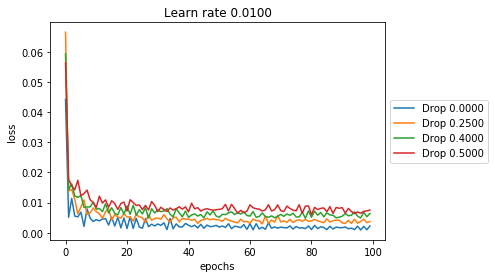


Learn rate: 0.0010
---------------------
 > Dropout: 0.00 Training error: 0.0010	Testing error: 0.0217
 > Dropout: 0.25 Training error: 0.0012	Testing error: 0.0538
 > Dropout: 0.40 Training error: 0.0015	Testing error: 0.0732
 > Dropout: 0.50 Training error: 0.0017	Testing error: 0.0923


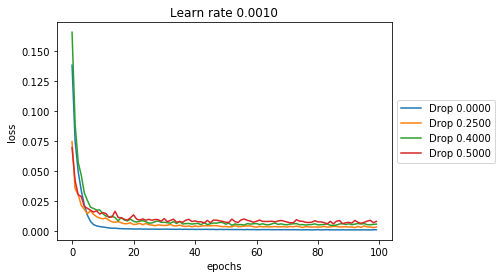


Learn rate: 0.0001
---------------------
 > Dropout: 0.00 Training error: 0.0019	Testing error: 0.0548
 > Dropout: 0.25 Training error: 0.0026	Testing error: 0.0511
 > Dropout: 0.40 Training error: 0.0062	Testing error: 0.0642
 > Dropout: 0.50 Training error: 0.0037	Testing error: 0.0355


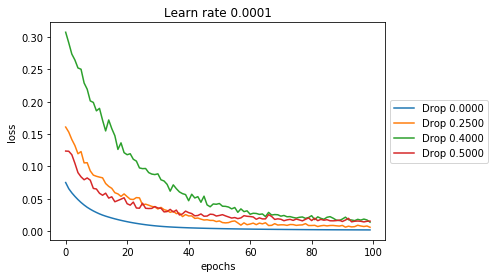

*** Best Live Model Summary***
Testing error: 0.0180
Best learning rate: 0.01
Best dropout rate: 0.25


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

window_size = 10
dropouts =  [0.0,0.25,0.4,0.50]
learn_rates = [0.01,0.001,0.0001]
batch_size = 50
epochs_live = 100

def test_live(X_train,y_train,X_test,y_test):
    best_model = None
    lowest_test_error = 2.0
    best_learn_rate = 0.0
    best_dropout_rate = 0.0
    for rate in learn_rates:
        print("\nLearn rate: {0:.4f}".format(rate))
        print('---------------------')
        lengend = []
        for dropout in dropouts:
            model = live_model(X_train,y_train,rate,dropout)
            history = model.fit(X_train, y_train, epochs=epochs_live, batch_size=batch_size, verbose=0)

            # print out training and testing errors
            training_error = model.evaluate(X_train, y_train, verbose=0)
            testing_error = model.evaluate(X_test, y_test, verbose=0)
            msg = " > Dropout: {0:.2f} Training error: {1:.4f}\tTesting error: {2:.4f}"
            print(msg.format(dropout, training_error,testing_error))
            
            #check if test error
            if lowest_test_error > testing_error:
                best_model = model
                lowest_test_error = testing_error
                best_learn_rate = rate
                best_dropout_rate = dropout
                
            #plot loss function
            plt.plot(history.history['loss'])
            lengend.append("Drop {0:.4f}".format(dropout)) 
    
        plt.title("Learn rate {0:.4f}".format(rate))
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend(lengend,loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
    
    return (best_model,lowest_test_error,best_learn_rate,best_dropout_rate)


seq_obj = MultiSequence(ticker,window_size,1)
dataset = seq_obj.original_data
X_train,y_train,X_test,y_test = split_data(seq_obj)

print("*** Live Model Testing ***")
print("=" * 40)        
results = test_live(X_train,y_train,X_test,y_test)


print("*** Best Live Model Summary***")
print("=" * 40) 
print("Testing error: {0:.4f}".format(results[1]))
print("Best learning rate: {}".format(results[2]))
print("Best dropout rate: {}".format(results[3]))

In [15]:
#get fourt tickers to perform out epoch test
ticker_epochs = [tickers[i][1] for i in range(4)]

window_size = 10
dropout_rate = 0.25
epochs_list = [50,100,200,500,1000]
batch_size = 50
learn_rate = 0.001

def test_epochs():
    """
    
    """
    for symbol in ticker_epochs:
        print("\nSymbol: {}".format(symbol))
        print('---------------------')
        seq_obj = MultiSequence(symbol,window_size,1)
        X_train,y_train,X_test,y_test = split_data(seq_obj)
        lowest_test_error = 2.0
        best_epoch = 0
        for epoch in epochs_list:
            model = live_model(X_train,y_train,learn_rate,dropout_rate)
            model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=0)

            # print out training and testing errors
            training_error = model.evaluate(X_train, y_train, verbose=0)
            testing_error = model.evaluate(X_test, y_test, verbose=0)
            msg = " > Epoch: {0:} \tTraining error: {1:.4f}\tTesting error: {2:.4f}"
            print(msg.format(epoch, training_error,testing_error))

            if lowest_test_error > testing_error:
                lowest_test_error = testing_error
                best_epoch = epoch
        
        #print best epoch for symbol
        print(" ==> Best epoch {0:} with testing error of {1:.4f}".format(best_epoch,lowest_test_error))

print("*** Epoch Model Testing ***")
print("=" * 40)        
test_epochs()

*** Epoch Model Testing ***

Symbol: MMM
---------------------
 > Epoch: 50 	Training error: 0.0040	Testing error: 0.0050
 > Epoch: 100 	Training error: 0.0029	Testing error: 0.0037
 > Epoch: 200 	Training error: 0.0028	Testing error: 0.0037
 > Epoch: 500 	Training error: 0.0028	Testing error: 0.0055
 > Epoch: 1000 	Training error: 0.0022	Testing error: 0.0044
 ==> Best epoch 100 with testing error of 0.0037

Symbol: AXP
---------------------
 > Epoch: 50 	Training error: 0.0028	Testing error: 0.0268
 > Epoch: 100 	Training error: 0.0026	Testing error: 0.0286
 > Epoch: 200 	Training error: 0.0024	Testing error: 0.0145
 > Epoch: 500 	Training error: 0.0023	Testing error: 0.0116
 > Epoch: 1000 	Training error: 0.0019	Testing error: 0.0136
 ==> Best epoch 500 with testing error of 0.0116

Symbol: AAPL
---------------------
 > Epoch: 50 	Training error: 0.0015	Testing error: 0.0816
 > Epoch: 100 	Training error: 0.0012	Testing error: 0.0568
 > Epoch: 200 	Training error: 0.0010	Testing err

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

ticker = tickers[0][1]
window_sizes = [5,7,10]
dropouts =  [0.0,0.25,0.4]
learn_rates = [0.01,0.001]
epochs = [100,200,500]
batch_size = 50

def best_model(ticker, window_sizes, learn_rates, dropouts, epochs, batch_size):
    """
    
    """
    #our best model variables
    best_model = None
    lowest_test_error = 2.0
    best_training_error =0.0
    best_learn_rate = 0.0
    best_dropout_rate = 0.0
    best_epoch = 0
    best_window_size = 0
    
    counter = 1
    
    for window_size in window_sizes:
        print("\nWindow size: {}".format(window_size))
        print('---------------------')
        
        #prepare our sequence data
        seq_obj = MultiSequence(ticker,window_size,1)
        X_train,y_train,X_test,y_test = split_data(seq_obj)    
    
        for rate in learn_rates:
            for dropout in dropouts:
                for epoch in epochs:
                    model = live_model(X_train,y_train,rate,dropout)
                    model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=0)

                    # print out training and testing errors
                    training_error = model.evaluate(X_train, y_train, verbose=0)
                    testing_error = model.evaluate(X_test, y_test, verbose=0)
                    msg = " > Learn rate: {0:.4f} Dropout: {1:.2f}"
                    msg += " Epoch: {2:} Training error: {3:.4f} Testing error: {4:.4f}"
                    msg = str(counter) + "   " +msg.format(rate,dropout, epoch, training_error, testing_error)
                    print(msg)

                    #check if test error 
                    if lowest_test_error > testing_error:
                        best_model = model
                        lowest_test_error = testing_error
                        best_learn_rate = rate
                        best_dropout_rate = dropout
                        best_epoch = epoch
                        best_training_error = training_error 
                        best_window_size = window_size
                    
                    #increase our print counter
                    counter += 1
                        
    best_dict ={}
    best_dict["ticker"] = ticker
    best_dict["model"] = best_model
    best_dict["test_error"] =   "{0:.4f}".format(lowest_test_error) 
    best_dict["learn_rate"] = best_learn_rate
    best_dict["dropout"] = best_dropout_rate
    best_dict["epoch"] = best_epoch
    best_dict["train_error"] =  "{0:.4f}".format(best_training_error)  
    best_dict["window_size"] = best_window_size
    
    return best_dict


print("*** Best Model Selection for {} ***".format(ticker))
print("=" * 40)      
results = best_model(ticker, window_sizes, learn_rates, dropouts, epochs, batch_size)

*** Best Model Selection for MMM ***

Window size: 5
---------------------
1    > Learn rate: 0.0100 Dropout: 0.00 Epoch: 100 Training error: 0.0039 Testing error: 0.0044
2    > Learn rate: 0.0100 Dropout: 0.00 Epoch: 200 Training error: 0.0023 Testing error: 0.0044
3    > Learn rate: 0.0100 Dropout: 0.00 Epoch: 500 Training error: 0.0012 Testing error: 0.0055
4    > Learn rate: 0.0100 Dropout: 0.25 Epoch: 100 Training error: 0.0045 Testing error: 0.0047
5    > Learn rate: 0.0100 Dropout: 0.25 Epoch: 200 Training error: 0.0040 Testing error: 0.0044
6    > Learn rate: 0.0100 Dropout: 0.25 Epoch: 500 Training error: 0.0030 Testing error: 0.0053
7    > Learn rate: 0.0100 Dropout: 0.40 Epoch: 100 Training error: 0.0047 Testing error: 0.0057
8    > Learn rate: 0.0100 Dropout: 0.40 Epoch: 200 Training error: 0.0053 Testing error: 0.0056
9    > Learn rate: 0.0100 Dropout: 0.40 Epoch: 500 Training error: 0.0034 Testing error: 0.0072
10    > Learn rate: 0.0010 Dropout: 0.00 Epoch: 100 Training 

*** Best Model Selected Summary for MMM ***
Window size: 7
Train error: 0.0031
Testing error: 0.0036
Learning rate: 0.001
Dropout rate: 0.0
Epochs: 100


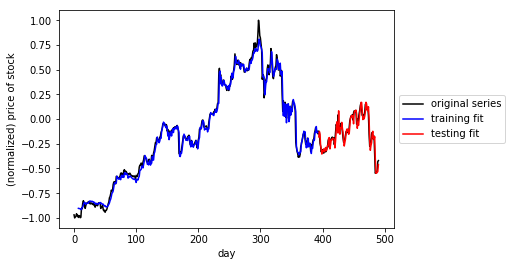

In [19]:
print("*** Best Model Selected Summary for {} ***".format(results["ticker"]))
print("=" * 40) 

print("Window size: {}".format(results["window_size"]))
print("Train error: {}".format(results["train_error"]))
print("Testing error: {}".format(results["test_error"]))
print("Learning rate: {}".format(results["learn_rate"]))
print("Dropout rate: {}".format(results["dropout"]))
print("Epochs: {}".format(results["epoch"]))

seq_obj = MultiSequence(results["ticker"],results["window_size"],1)
dataset = seq_obj.original_data
X_train,y_train,X_test,y_test = split_data(seq_obj)

graph_prediction(results["model"], X_train,X_test,dataset,results["window_size"])